# `depiction` - A meta-interpretability toolbox

## Why interpretability?

In the last decade, the application of deep neural networks to long-standing problems has brought a break-through in performance and prediction power. However, high accuracy, deriving from the increased model complexity, often comes at the price of loss of interpretability, i.e., many of these models behave as black-boxes and fail to provide explanations on their predictions. While in certain application fields this issue may play a secondary role, in high risk domains, e.g., health care, it is crucial to build trust in a model and being able to understand its behaviour.

## What is interpretability?

The definition of the verb *interpret* is "to explain or tell the meaning of : present in understandable terms" ([Merriam-Webster 2019](https://www.merriam-webster.com/dictionary/interpret)). Despite the apparent simplicity of this statement, the machine learning research community is struggling to agree upon a formal definition of the concept of interpretability/explainability. In the last years, in the room left by this lack of formalism, many methodologies have been proposed based on different "interpretations" (pun intended) of the above defintion. While the proliferation of this multitude of disparate algorithms has posed challenges on rigorously comparing them, it is nevertheless interesting and useful to apply these techniques to analyze the behaviour of deep learning models.

## `depiction`

The group of Cognitive Health Care and Life Sciences at IBM Research Zürich has opensourced a python toolbox, [`depiction`](https://github.com/IBM/depiction), with the aim of providing a framework to ease the application of explainability methods on custom models, especially for less experienced users. The module provide wrappers for multiple algorithms and is continously updated including the latest algorithms from [AIX360](https://github.com/IBM/AIX360.git). The core concept behind `depiction` is to allow users to seamlessly run state-of-art interpretability methods with minimal requirements in terms of programming skills. Below an example of how `depiction` can be used to analyze a pretrained model.

### A simple example - Wrapping a pretrained Keras Model

Let's assume to have a fancy model for classification of tabular data pretrained in Keras and available at a public url. Explaining its predictions with `depiction` is easy as implementing a lightweight wrapper of `depiction.models.uri.HTTPModel` where its `predict` method is overridden.

```python
from depiction.core import Task, DataType
from depiction.models.uri import HTTPModel


class FancyModel(HTTPModel):
    """A fancy classifier."""


    def __init__(self,
        filename='fancy_model.h5',
        origin='https://url/to/my/fancy_model.h5',
        cache_dir='/path/to/cache/models',
        *args, **kwargs):
        """Initialize the FancyModel."""
        super().__init__(
            uri=origin,
            task=Task.CLASSIFICATION,
            data_type=DataType.TABULAR,
            cache_dir=cache_dir,
            filename=filename
        )
        self.model = keras.models.load_model(self.model_path)

    def predict(self, sample, *args, **kwargs):
        """
        Run the fancy model for inference on a given sample and with the provided
        parameters.

        Args:
            sample (object): an input sample for the model.
            args (list): list of arguments.
            kwargs (dict): list of key-value arguments.

        Returns:
            a prediction for the model on the given sample.
        """
        return self.model.predict(
            sample,
            batch_size=None, verbose=0,
            steps=None, callbacks=None
        )
```

Once `FancyModel` is implemented, using any of the `depiction.interpreters` available in the library, is as easy as typing:

```python
fancy_model = FancyModel()
# NOTE: interpreters are implemented inheriting from
# depiction.interpreters.base.base_interpreter.BaseInterpreter
# and they share a common interface.
explanations = interpreter.interpret(example)
```

### Run an intepreter from AIX360 - Rule-based interpretable method

In [1]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', -1)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import neural_network
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from depiction.core import Task, DataType
from depiction.models.base import BinarizedClassifier
from depiction.interpreters.aix360.rule_based_model import RuleAIX360

Here we show as an example how *easy* is to use **Generalized linear rule models** in `depiction` [(Wei D. et al. 2019)](http://proceedings.mlr.press/v97/wei19a/wei19a.pdf).

#### Get the data
Let's get some data to play with.

In [2]:
# Create a dataset. 
dataset = load_iris()

# Rule-based explainers work only with binary classifiers.
# In this example, we want to explain class 'setosa'
X = pd.DataFrame(dataset.data, columns=dataset.feature_names)
y_one_hot = OneHotEncoder().fit_transform(dataset.target.reshape(-1, 1)).todense()

label = 'setosa'
label_index = np.where(dataset.target_names == label)[0].item()
y = np.array(dataset.target == label_index).astype(np.int).flatten()

# NOTE: for the purpose of this example, we avoid to generate a validation split.
X_train, X_test, y_train, y_test, y_train_one_hot, y_test_one_hot = train_test_split(
    X, y, y_one_hot, test_size=0.33, random_state=42, stratify=y
)

#### Ante-hoc version
In the following we are using the model as an *ante-hoc global interpretable method*.

In [3]:
# Create explainable model, interpreting the whole dataset
ante_hoc_model = RuleAIX360('glrm_linear', X=X, y=y)

In [4]:
# Explain model
ante_hoc_model.interpret();

                                                   rule coefficient
0  (intercept)                                           0.524881  
1  sepal width (cm) > 2.70 AND petal width (cm) <= 1.16  0.616186  
2  petal length (cm) > 1.70 AND petal width (cm) > 0.40 -0.587525  
3  sepal length (cm) > 5.27 AND petal width (cm) > 0.40 -0.0871229 
4  sepal width (cm) <= 3.20 AND petal width (cm) > 0.40 -0.0698256 
5  petal width (cm) <= 1.16                              0.0311023 
6  petal width (cm) <= 0.40                              0.0122838 
7  petal length (cm) <= 1.70                             0.012283  
8  petal length (cm) <= 3.90                            -0.00140309


Since the *iris* dataset is a relatively easy one, i.e., it can be solved with a linear model, we can easily double check if the rules learned by the **interpretable model** make sense. In the following, we show the samples from the dataset on a 2D plot where the axes are the *sepal width* and *petal width*. The *setosa* samples are shown in blue, while the others are in red. The blue area denotes the region described by the most important rule inferred by the interpretable model (line 1 of the output).

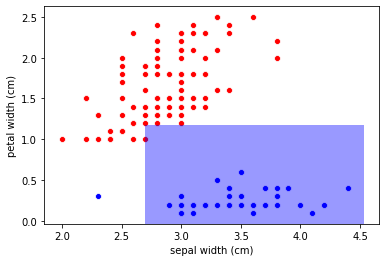

In [5]:
sns.scatterplot(x='sepal width (cm)', y='petal width (cm)', data=X.iloc[y == 1], color='b')
sns.scatterplot(x='sepal width (cm)', y='petal width (cm)', data=X.iloc[y == 0], color='r')
ax = plt.gca()
_ = ax.axvspan(
    xmin=2.70, xmax=ax.get_xlim()[1], ymin=0, ymax=(1.16 - ax.get_ylim()[0])/ax.get_ylim()[1],
    facecolor='b', alpha=0.4
)

![already_trained](https://memeshappen.com/media/created/2019/12/Hmmmm-What-if-I-have-an-already-trained-model.jpg)

#### Post-hoc version
In the following we are using the model as a *post-hoc global interpretable method*, by analysing a very bad MLP.

In [6]:
# train a dummy model to interpret
classifier = neural_network.MLPClassifier(hidden_layer_sizes=(8,), alpha=0.0001, random_state=84)
_ = classifier.fit(X_train, y_train_one_hot)
print("Accuracy: {}".format(accuracy_score(y_test_one_hot, classifier.predict(X_test))))

Accuracy: 0.7


This a pretty bad performance on the IRIS dataset. Let's assume that we are in a real word scenario, and we actually don't know that we are dealing with an MLP, i.e. let's assume we are dealing with a *black-box* model. Can we get a feeling of what is going wrong in the model? Let's use the Generalised Linear Rule Model in a post-hoc fashion!

In [7]:
# First, binarize the model to be compatible with the rule-based interpreter
model = BinarizedClassifier(
    classifier, data_type=DataType.TABULAR,
    label_index=label_index
)
# Create explainable model, interpreting the model
post_hoc_model = RuleAIX360(
    'glrm_logistic', X=X_test,
    # binarize the model to be compatible with the rule-based interpreter
    model=model
)

In [8]:
# Explain model
post_hoc_model.interpret();

                                                    rule coefficient
0  (intercept)                                           -0.712175  
1  sepal width (cm) > 2.70 AND petal length (cm) <= 5.23  11.2239   
2  petal length (cm) > 4.65                              -5.21811   
3  petal length (cm) <= 4.65                              4.62463   
4  petal length (cm) > 5.23                              -2.89786   
5  petal length (cm) <= 5.23                              2.30438   
6  petal length (cm) > 5.04                              -0.853485  
7  petal length (cm) <= 5.04                              0.260006  


Okay, our interpretability method unveiled the underlying classification rules of the MLP. Let's visualize them.
Here we show the predictions of the MLP on the test samples (left) and the ground truth (right) on a 2D plot with *petal length* and *sepal width* on the axes. We use the same color coding as before: *setosa* samples are blue, the others are red, and the area described by the most important rule (line 1 of the rule list) is in blue. 

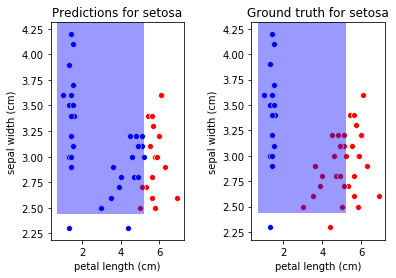

In [9]:
# Plot MLP predictions
ax = plt.subplot(1,2,1)
y_hat = model.predict(X_test)
sns.scatterplot(x="petal length (cm)", y="sepal width (cm)", data=X_test.iloc[y_hat == 1], color='b')
sns.scatterplot(x="petal length (cm)", y="sepal width (cm)", data=X_test.iloc[y_hat == 0], color='r')
_ = ax.axvspan(
    xmin=ax.get_xlim()[0], xmax=5.23, ymin=(2.7 - ax.get_ylim()[0])/ax.get_ylim()[1], ymax=1.0,
    facecolor='b', alpha=0.4
)
ax.set_title('Predictions for setosa')

# Plot ground truth
ax = plt.subplot(1,2,2)
sns.scatterplot(x="petal length (cm)", y="sepal width (cm)", data=X_test.iloc[y_test == 1], color='b')
sns.scatterplot(x="petal length (cm)", y="sepal width (cm)", data=X_test.iloc[y_test == 0], color='r')
_ = ax.axvspan(
    xmin=ax.get_xlim()[0], xmax=5.23, ymin=(2.7 - ax.get_ylim()[0])/ax.get_ylim()[1], ymax=1.0,
    facecolor='b', alpha=0.4
)
ax.set_title('Ground truth for setosa')

plt.subplots_adjust(wspace=0.5)

As we can see there are quite some samples that are misclassified. The interpretable method helps us see why: apparently the MLP is using the *petal length* in the "wrong way", by thresholding it incorrectly. This is evident from the misclassification of the points with *petal length* values between 3 and 5. We'd call this a successful debugging! *Hurray*!

## Want to know more?

![tell_me_more](https://memeshappen.com/media/created/2019/12/Youve-got-my-attention-Tell-me-more.jpg)

This is the first post in a series from the Cognitive Health Care and Life Sciences at IBM Research Zürich and was authored by [An-phi Nguyen](http://researcher.watson.ibm.com/researcher/view.php?person=zurich-UYE) ([github](https://github.com/phineasng), [twitter](https://twitter.com/phineas_zu)), [Joris Cadow](https://researcher.watson.ibm.com/researcher/view.php?person=zurich-DOW) ([github](https://github.com/C-nit/), [twitter](https://twitter.com/tse_nit)), and [Matteo Manica](http://researcher.watson.ibm.com/researcher/view.php?person=zurich-TTE) ([github](https://github.com/drugilsberg), [twitter](https://twitter.com/drugilsberg)). If you found this blog post interesting and you want to know more about `depiction`. Just take a look at the repo, the examples and the workshop in our [repo](https://github.com/IBM/depiction).